In [45]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


import string
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import multiprocessing as mp
import re

In [46]:
df = pd.read_csv('Reviews.csv')

In [47]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [49]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [50]:
df= df.dropna()

In [51]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [52]:
df.shape

(568411, 10)

In [53]:
#Selecting the reviews which are having lowest rating
df['ReviewBad'] = df.Score < 3

In [54]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewBad
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,False
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,True
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,False
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,True
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,False


In [55]:
# selecting only first 10000 rows
df_bad_reviews= df.loc[df.ReviewBad ==True][0:250] 

In [56]:
df_bad_reviews.shape

(250, 11)

In [57]:
df_bad_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewBad
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,True
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,True
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,True
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,True
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",True


In [58]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manik.hendre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\manik.hendre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manik.hendre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [60]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub(r'\b\w{1,3}\b', '', sent) # remove words less than 3 characters
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [61]:
# Convert to list
data = df_bad_reviews.Text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', 'sure', 'this', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo']]


In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [63]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [64]:
data_ready = process_words(data_words)  # processed Text Data!

In [65]:
data_ready[0]

['product',
 'peanut',
 'peanut',
 'small',
 'sized',
 'unsalted',
 'sure',
 'error',
 'vendor',
 'represent',
 'product',
 'jumbo']

In [75]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=100,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.032*"food" + 0.020*"disappointed" + 0.019*"purchase" + 0.014*"time" + '
  '0.012*"cake" + 0.011*"fact" + 0.009*"horrible" + 0.008*"frosting" + '
  '0.008*"edible" + 0.007*"adult"'),
 (1,
  '0.038*"bag" + 0.020*"package" + 0.013*"date" + 0.013*"money" + '
  '0.012*"natural" + 0.011*"time" + 0.010*"enough" + 0.010*"week" + '
  '0.010*"potato" + 0.009*"quality"'),
 (2,
  '0.055*"product" + 0.027*"taste" + 0.016*"order" + 0.011*"review" + '
  '0.011*"different" + 0.010*"company" + 0.009*"food" + 0.009*"people" + '
  '0.008*"coffee" + 0.008*"much"'),
 (3,
  '0.061*"chip" + 0.043*"flavor" + 0.014*"price" + 0.013*"cookie" + '
  '0.012*"ingredient" + 0.010*"tiny" + 0.010*"texture" + 0.009*"thing" + '
  '0.009*"case" + 0.009*"one"')]


In [68]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.368960277801864


In [69]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')

In [70]:
coherence_model_lda.get_coherence()  # get coherence value

0.3892058343523202

In [71]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [72]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9421,"product, taste, order, review, different, comp...","[product, peanut, peanut, small, sized, unsalt..."
1,1,1.0,0.7540,"bag, package, date, money, natural, time, enou...","[secret, addition, root, beer, cherry, soda]"
2,2,0.0,0.9554,"food, disappointed, purchase, time, cake, fact...","[cat, felidae, platinum, year, food, food, bow..."
3,3,1.0,0.9232,"bag, package, date, money, natural, time, enou...","[love, looking, movie, sweet, transfer, lock, ..."
4,4,0.0,0.2500,"food, disappointed, purchase, time, cake, fact...",[]
5,5,1.0,0.6249,"bag, package, date, money, natural, time, enou...",[soft]
6,6,1.0,0.8497,"bag, package, date, money, natural, time, enou...","[arrived, day, stale, bag]"
7,7,1.0,0.6946,"bag, package, date, money, natural, time, enou...","[hint, sweetness, various, sport, nutrition, p..."
8,8,2.0,0.9065,"product, taste, order, review, different, comp...","[buyer_beware, sugar, undigestible, body, shor..."
9,9,0.0,0.2500,"food, disappointed, purchase, time, cake, fact...",[]


In [28]:
df_dominant_topic['ratings'] = df_bad_reviews['Score'].values

In [132]:
#df_dominant_topic['Text'] = df_bad_reviews['Text'].values

In [29]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,ratings
0,0,2.0,0.9421,"product, taste, order, review, different, comp...","[product, peanut, peanut, small, sized, unsalt...",1
1,1,1.0,0.7540,"bag, package, date, money, natural, time, enou...","[secret, addition, root, beer, cherry, soda]",2
2,2,0.0,0.9554,"food, disappointed, purchase, time, cake, fact...","[cat, felidae, platinum, year, food, food, bow...",1
3,3,1.0,0.9232,"bag, package, date, money, natural, time, enou...","[love, looking, movie, sweet, transfer, lock, ...",2
4,4,0.0,0.2500,"food, disappointed, purchase, time, cake, fact...",[],1


In [30]:
def commonWords(s0, s1):
    s1 = ', '.join([str(elem) for elem in s1]) 
    s0 = s0.lower()
    s1 = s1.lower()
    s0List = s0.split(",")
    s1List = s1.split(",")
    return list(set(s0List)&set(s1List))

In [31]:
dfNew = df_dominant_topic.apply(lambda x: commonWords(x.Keywords, x.Text), axis=1)

In [32]:
finalTopicModeldf = df_dominant_topic.copy()

In [33]:
finalTopicModeldf.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,ratings
0,0,2.0,0.9421,"product, taste, order, review, different, comp...","[product, peanut, peanut, small, sized, unsalt...",1
1,1,1.0,0.7540,"bag, package, date, money, natural, time, enou...","[secret, addition, root, beer, cherry, soda]",2
2,2,0.0,0.9554,"food, disappointed, purchase, time, cake, fact...","[cat, felidae, platinum, year, food, food, bow...",1
3,3,1.0,0.9232,"bag, package, date, money, natural, time, enou...","[love, looking, movie, sweet, transfer, lock, ...",2
4,4,0.0,0.2500,"food, disappointed, purchase, time, cake, fact...",[],1


In [34]:
finalTopicModeldf['Keywords'] = dfNew

In [35]:
finalTopicModeldf['Text'] = df_bad_reviews['Text'].values

In [36]:
finalTopicModeldf.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,ratings
0,0,2.0,0.9421,[product],Product arrived labeled as Jumbo Salted Peanut...,1
1,1,1.0,0.7540,[],If you are looking for the secret ingredient i...,2
2,2,0.0,0.9554,[],My cats have been happily eating Felidae Plati...,1
3,3,1.0,0.9232,[ time],I love eating them and they are good for watch...,2
4,4,0.0,0.2500,[],"The candy is just red , No flavor . Just plan...",1


In [37]:
finalTopicModeldf.to_csv("NounAdjective_Reviews_dominant_topic_Amazon_commonKeywords.csv")

In [38]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

C:\Users\manik.hendre\Anaconda3\envs\py3.5\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\manik.hendre\Anaconda3\envs\py3.5\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\manik.hendre\Anaconda3\envs\py3.5\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\manik.hendre\Anaconda3\envs\py3.5\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


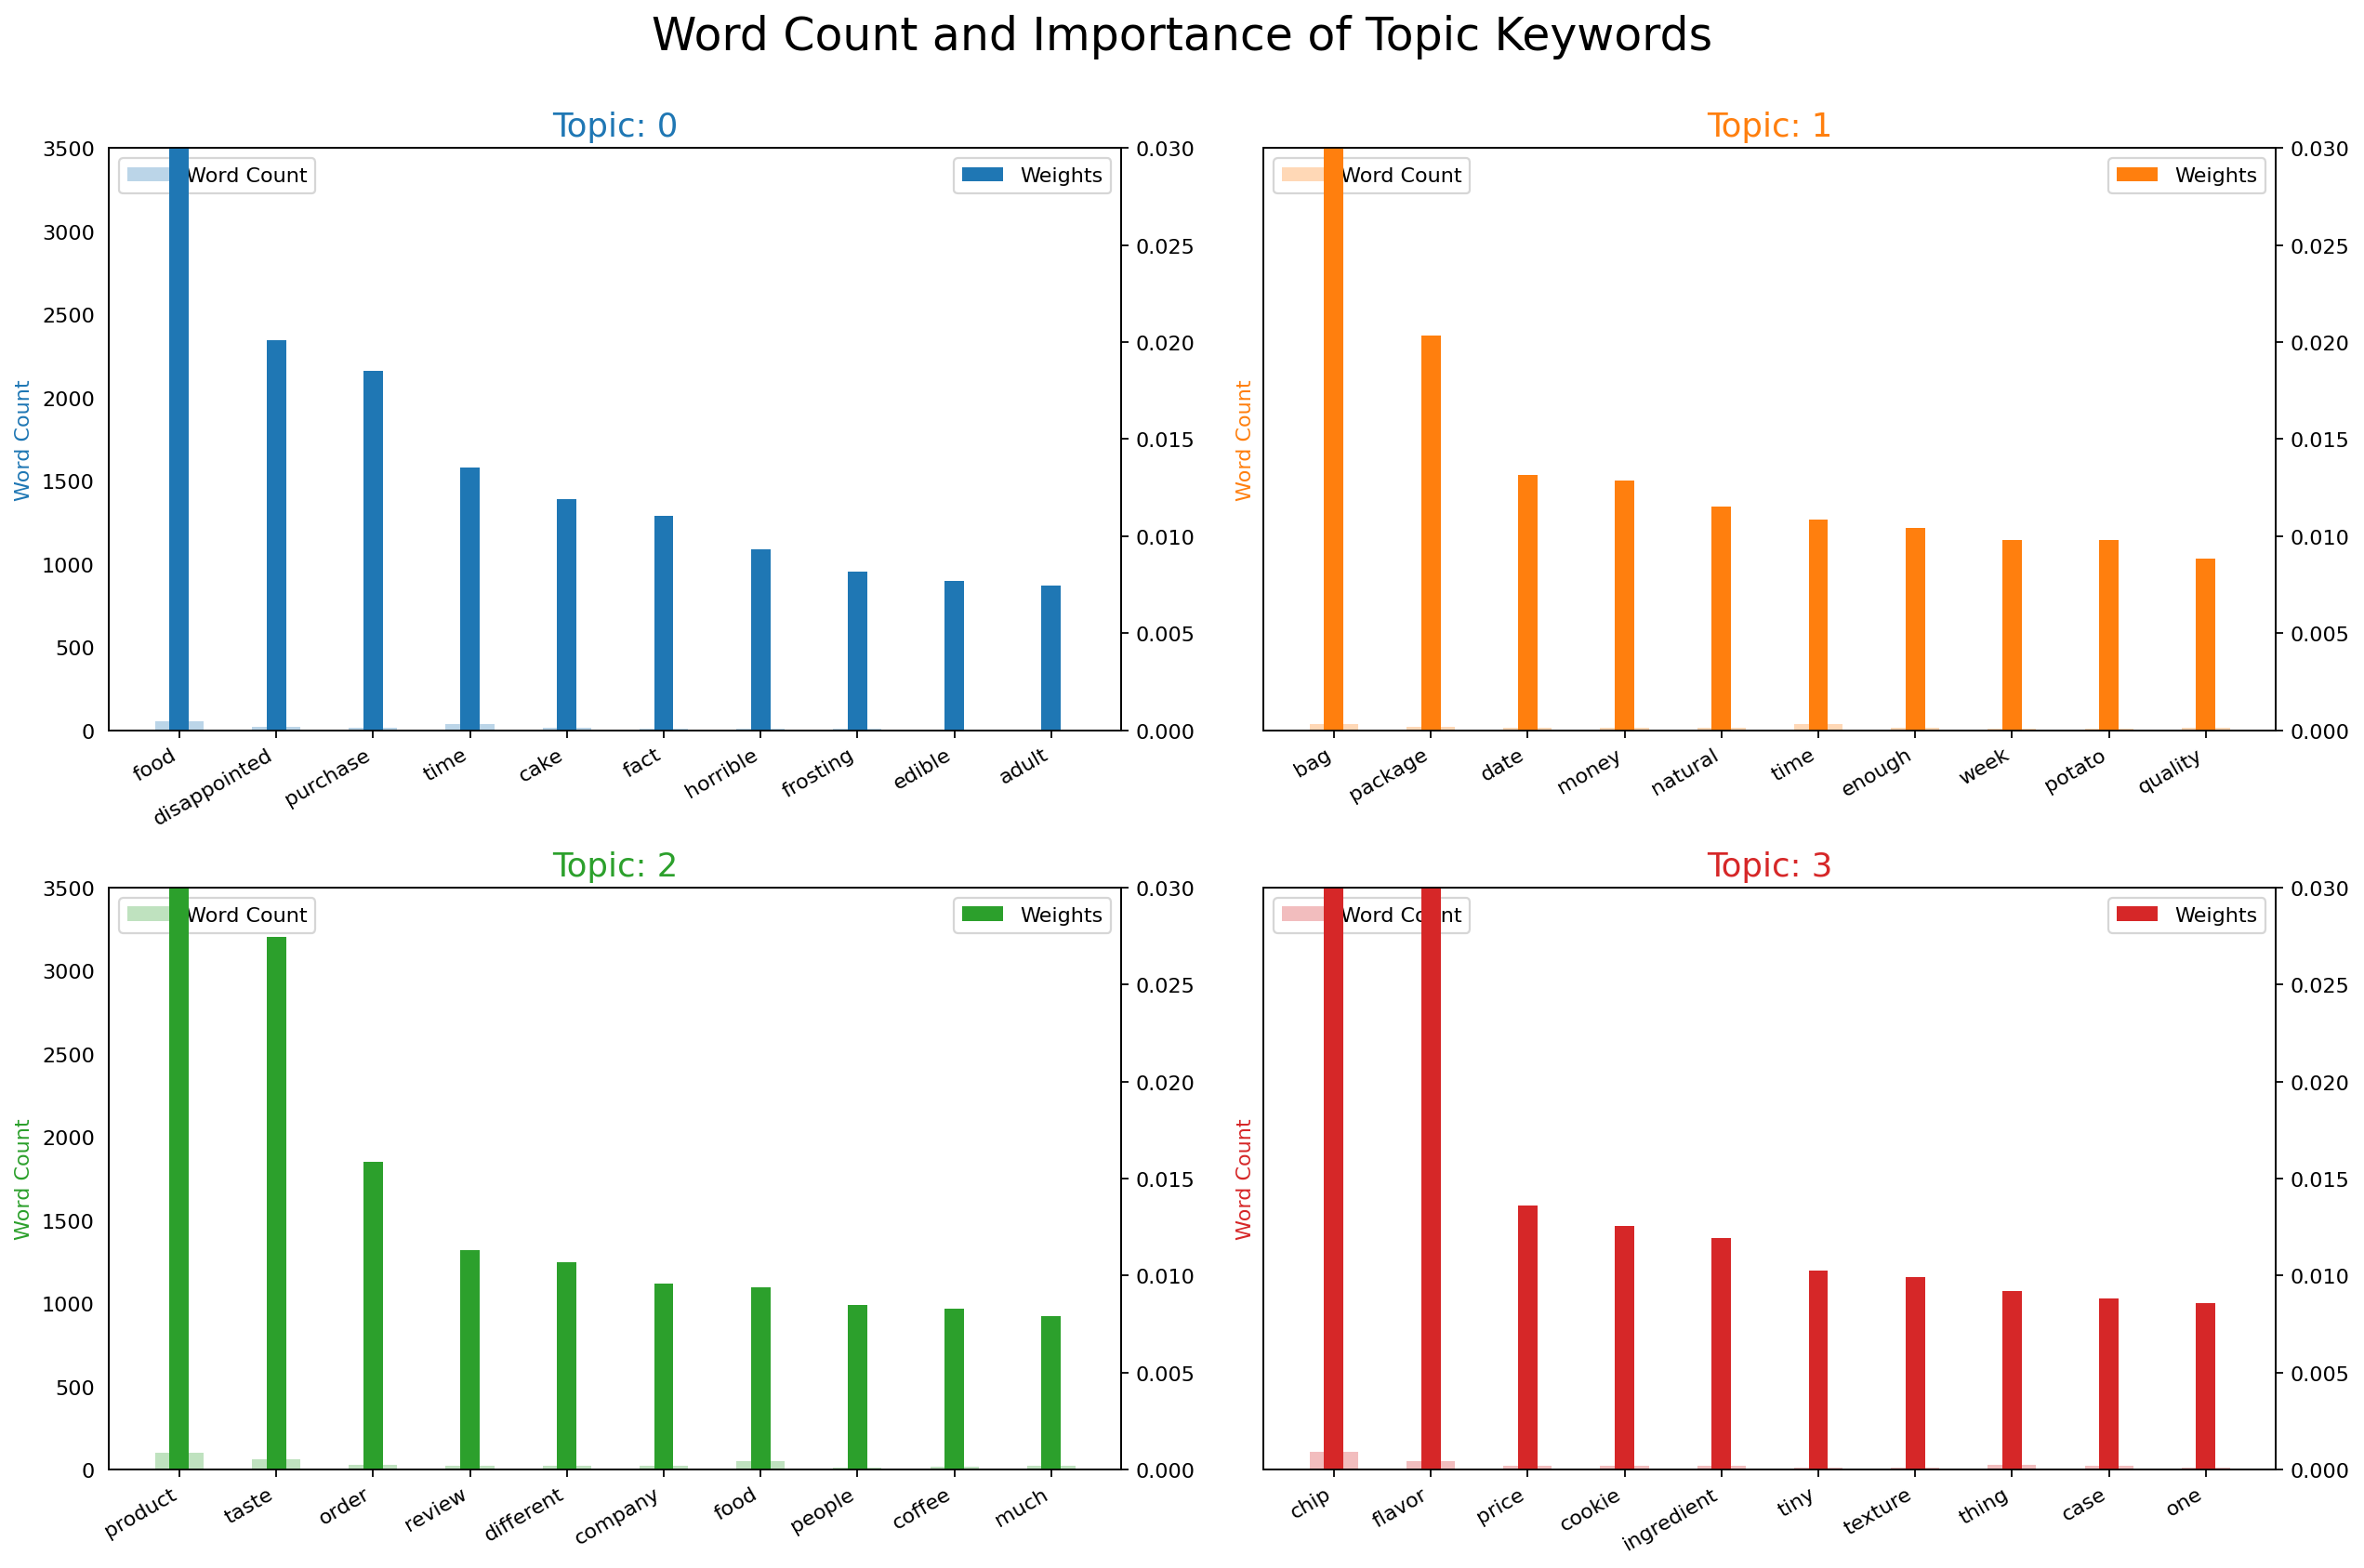

In [39]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [40]:
!pip install pyLDAvis

In [68]:
!pip install matplotlib

In [41]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.207323  0.080273       1        1  37.406881
3     -0.177325  0.139648       2        1  27.186273
1     -0.045478 -0.189063       3        1  20.587908
0      0.015480 -0.030858       4        1  14.818938, topic_info=        Term       Freq      Total Category  logprob  loglift
377     chip  72.000000  72.000000  Default  30.0000  30.0000
3    product  89.000000  89.000000  Default  29.0000  29.0000
110   flavor  50.000000  50.000000  Default  28.0000  28.0000
39       bag  34.000000  34.000000  Default  27.0000  27.0000
20      food  36.000000  36.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
35      time   8.674654  25.770122   Topic4  -4.3020   0.8205
158     well   3.271593   8.306546   Topic4  -5.2772   0.9775
197  regular   2.945112   8.736170   Topic4  -5.3823   0.8219
148    store   3.059584  14.881320   Topic4  -5.3442   0.3274
25    review   3.239397  21.944724   Topic4  -5.2871  -0.0039

[180 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
960       4  0.938352        adult
1355      2  0.965254  alternative
1010      2  0.820223    available
437       2  0.973857        awful
947       4  0.859463         baby
...     ...       ...          ...
111       2  0.918472        whole
1396      4  0.940647        worth
27        1  0.681799         year
27        3  0.075755         year
27        4  0.227266         year

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])